<a href="https://colab.research.google.com/github/cdiegor/MineracaoDeDados/blob/main/Reconhecimento_de_caracteres_com_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Laboratório — Classificação de Imagens com SVM

Neste notebook vamos praticar o uso do **framework de Máquinas de Vetor de Suporte (SVM)** em um problema de **reconhecimento de imagens**.

Usaremos o conjunto **`digits`** do `scikit-learn` (imagens 8×8 em tons de cinza de dígitos escritos à mão) e exploraremos:

- Carregamento e visualização das imagens  
- Separação em treino / validação / teste  
- SVM com kernel **linear** e **RBF**  
- Ajuste de hiperparâmetros **C** e **gamma** com `GridSearchCV`  
- Avaliação com acurácia, *classification report* e matriz de confusão  
- (Opcional) Projeção em 2D com PCA e visualização da fronteira de decisão para um par de dígitos


In [ ]:

# --- Setup ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold,
    learning_curve, validation_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA

sns.set(style="whitegrid")
np.random.seed(7)



## 1. Carregar e inspecionar o *dataset* de imagens

Usaremos o `digits`:

- 1797 amostras  
- Imagens 8×8 em tons de cinza (valores em `[0, 16]`)  
- 10 classes: dígitos **0–9**


In [ ]:

digits = datasets.load_digits()
X = digits.data          # shape (n_amostras, 64)
y = digits.target        # rótulos 0-9

print("Formato de X:", X.shape)
print("Formato de y:", y.shape)
print("Classes:", np.unique(y))


Formato de X: (1797, 64)
Formato de y: (1797,)
Classes: [0 1 2 3 4 5 6 7 8 9]


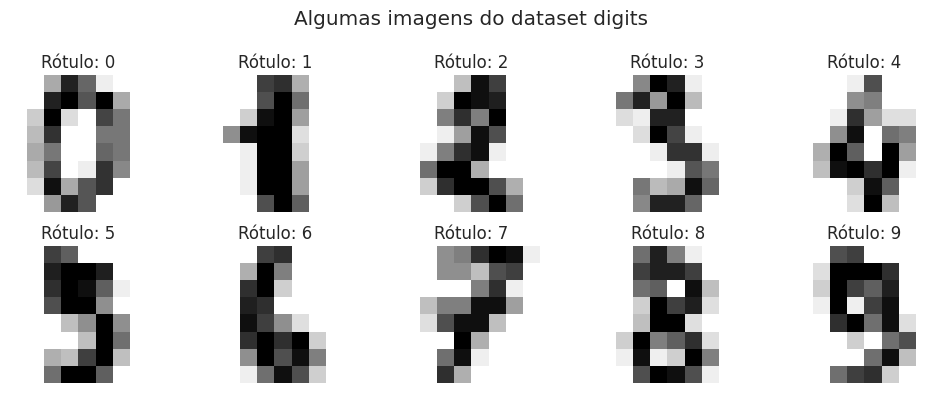

In [ ]:

# Visualizar algumas imagens de exemplo
n_rows, n_cols = 2, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 4))

for i, ax in enumerate(axes.ravel()):
    ax.imshow(digits.images[i], cmap="gray_r")
    ax.set_title(f"Rótulo: {y[i]}")
    ax.axis("off")

plt.suptitle("Algumas imagens do dataset digits")
plt.tight_layout()
plt.show()



## 2. Separação treino / teste e *pipeline*

Vamos criar um conjunto de **teste** (hold-out) e usar o restante para **treino + validação** (via validação cruzada).

Também definimos um `Pipeline` que faz:

1. Padronização (`StandardScaler`)  
2. Classificação com SVM (`SVC`)


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Tamanho treino:", X_train.shape[0], "| Tamanho teste:", X_test.shape[0])

# Pipeline base com kernel RBF (parâmetros serão tunados depois)
base_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf"))
])


Tamanho treino: 1437 | Tamanho teste: 360



## 3. Modelos SVM básicos

Começamos com dois modelos simples:

- **SVM linear** (`LinearSVC`)  
- **SVM RBF** (`SVC(kernel="rbf")` com parâmetros fixos)


In [ ]:

# SVM linear (one-vs-rest)
linear_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(C=1.0, random_state=42))
])

linear_clf.fit(X_train, y_train)
y_pred_lin = linear_clf.predict(X_test)
acc_lin = accuracy_score(y_test, y_pred_lin)

print(f"Acurácia SVM linear no teste: {acc_lin:.4f}")
print("\nRelatório de classificação (SVM linear):")
print(classification_report(y_test, y_pred_lin))


Acurácia SVM linear no teste: 0.9556

Relatório de classificação (SVM linear):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.91      0.86      0.89        36
           2       1.00      1.00      1.00        35
           3       0.97      0.97      0.97        37
           4       0.92      1.00      0.96        36
           5       0.97      1.00      0.99        37
           6       0.94      0.94      0.94        36
           7       0.95      0.97      0.96        36
           8       0.89      0.89      0.89        35
           9       1.00      0.92      0.96        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



In [ ]:

# SVM com kernel RBF (parâmetros iniciais)
rbf_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", C=10.0, gamma=0.01))
])

rbf_clf.fit(X_train, y_train)
y_pred_rbf = rbf_clf.predict(X_test)
acc_rbf = accuracy_score(y_test, y_pred_rbf)

print(f"Acurácia SVM RBF no teste: {acc_rbf:.4f}")
print("\nRelatório de classificação (SVM RBF):")
print(classification_report(y_test, y_pred_rbf))


Acurácia SVM RBF no teste: 0.9833

Relatório de classificação (SVM RBF):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.97      0.97      0.97        36
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        37
           4       0.95      0.97      0.96        36
           5       1.00      1.00      1.00        37
           6       0.97      1.00      0.99        36
           7       0.95      1.00      0.97        36
           8       1.00      0.94      0.97        35
           9       1.00      0.94      0.97        36

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



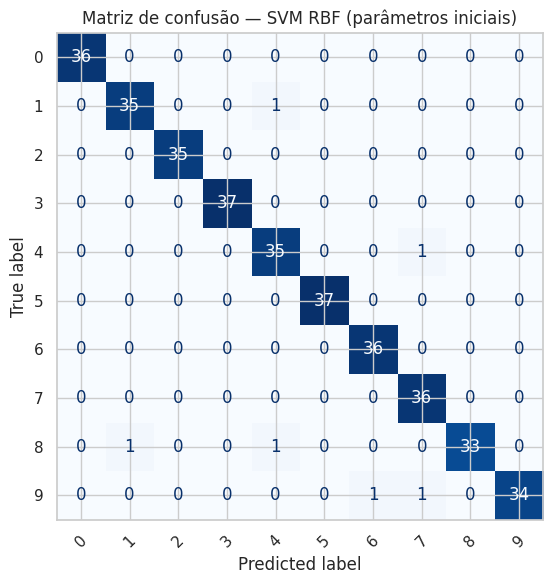

In [ ]:

# Matriz de confusão para o SVM RBF básico
cm = confusion_matrix(y_test, y_pred_rbf)

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=digits.target_names)
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Matriz de confusão — SVM RBF (parâmetros iniciais)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## 4. Ajuste de hiperparâmetros para SVM RBF

Agora vamos ajustar **C** (força de regularização) e **gamma** (largura do kernel RBF) usando `GridSearchCV` com validação cruzada estratificada (5 *folds*).


In [ ]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": [0.001, 0.01, 0.1]
}

grid = GridSearchCV(
    estimator=base_pipeline,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    scoring="accuracy",
    verbose=1
)

grid.fit(X_train, y_train)

print("Melhores hiperparâmetros:", grid.best_params_)
print("Melhor acurácia média em CV:", grid.best_score_)

best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
acc_best = accuracy_score(y_test, y_pred_best)
print(f"Acurácia no teste com SVM RBF ajustado: {acc_best:.4f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhores hiperparâmetros: {'svm__C': 10, 'svm__gamma': 0.01}
Melhor acurácia média em CV: 0.9791206929926443
Acurácia no teste com SVM RBF ajustado: 0.9833



## 5. *Validation curves*: efeito de C e gamma

Para entender melhor o comportamento do SVM, vamos plotar **curvas de validação** para C e gamma separadamente.


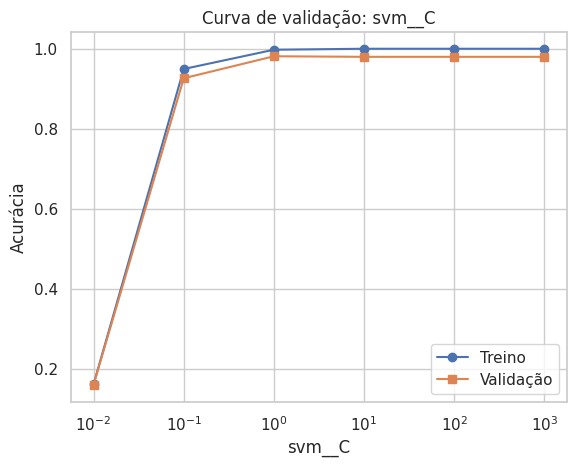

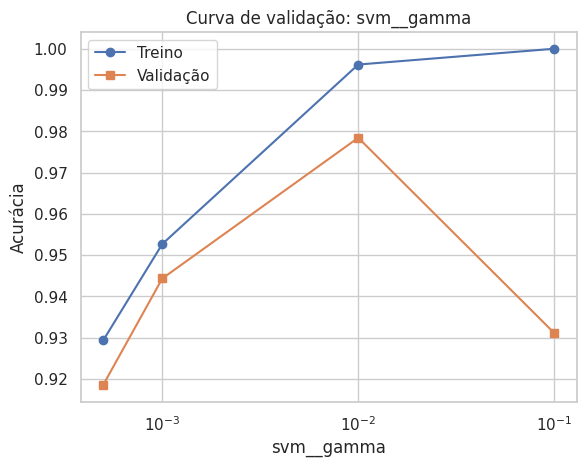

In [ ]:

param_range_C = [0.01, 0.1, 1, 10, 100, 1000]
param_range_gamma = [0.0005, 0.001, 0.01, 0.1]

from sklearn.model_selection import validation_curve

def plot_validation_curve(param_name, param_range):
    train_scores, val_scores = validation_curve(
        base_pipeline, X_train, y_train,
        param_name=param_name,
        param_range=param_range,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1
    )
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure()
    plt.semilogx(param_range, train_mean, marker="o", label="Treino")
    plt.semilogx(param_range, val_mean, marker="s", label="Validação")
    plt.xlabel(param_name)
    plt.ylabel("Acurácia")
    plt.title(f"Curva de validação: {param_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_validation_curve("svm__C", param_range_C)
plot_validation_curve("svm__gamma", param_range_gamma)



## 6. *Learning curve* (curva de aprendizado) para o modelo ajustado

Vamos observar como a performance evolui à medida que aumentamos o número de exemplos de treino.


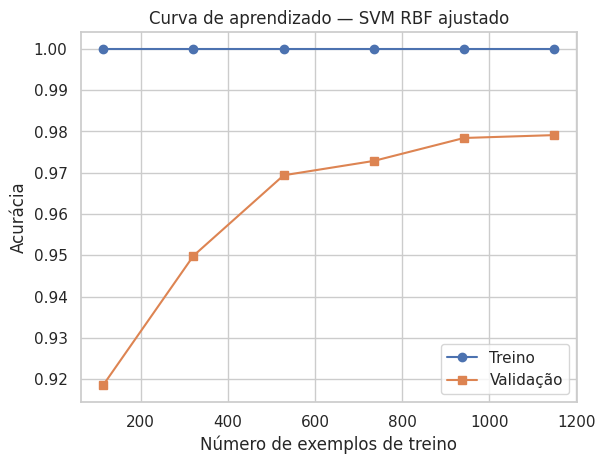

In [ ]:

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train,
    cv=cv,
    train_sizes=np.linspace(0.1, 1.0, 6),
    scoring="accuracy",
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, marker="o", label="Treino")
plt.plot(train_sizes, val_mean, marker="s", label="Validação")
plt.xlabel("Número de exemplos de treino")
plt.ylabel("Acurácia")
plt.title("Curva de aprendizado — SVM RBF ajustado")
plt.grid(True)
plt.legend()
plt.show()



## 7. (Opcional) PCA em 2D e fronteira de decisão para dígitos 0 vs 1

Para visualizar a geometria do SVM, vamos:

1. Filtrar apenas os dígitos **0** e **1**  
2. Projetar as imagens em 2D com **PCA**  
3. Treinar um SVM linear nesse espaço 2D e plotar a fronteira de decisão


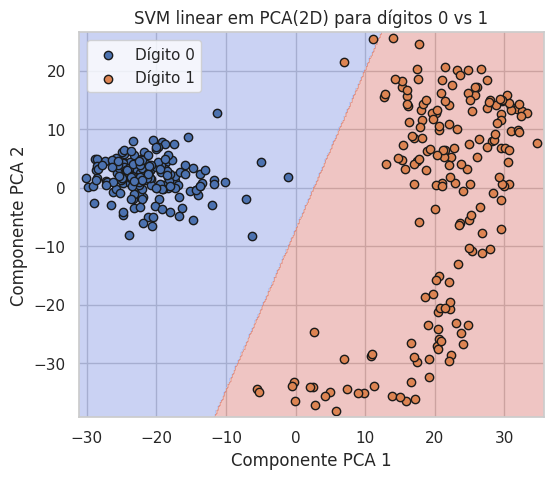

In [ ]:

# Selecionar apenas dígitos 0 e 1
mask_01 = np.isin(y, [0, 1])
X01 = X[mask_01]
y01 = y[mask_01]

# Projeção PCA para 2 dimensões
pca = PCA(n_components=2)
X01_2d = pca.fit_transform(X01)

X01_train, X01_test, y01_train, y01_test = train_test_split(
    X01_2d, y01, test_size=0.2, stratify=y01, random_state=42
)

svm_2d = SVC(kernel="linear", C=1.0)
svm_2d.fit(X01_train, y01_train)

# Grelha para fronteira de decisão
x_min, x_max = X01_2d[:, 0].min() - 1, X01_2d[:, 0].max() + 1
y_min, y_max = X01_2d[:, 1].min() - 1, X01_2d[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
plt.scatter(X01_2d[y01 == 0, 0], X01_2d[y01 == 0, 1], label="Dígito 0", edgecolor="k")
plt.scatter(X01_2d[y01 == 1, 0], X01_2d[y01 == 1, 1], label="Dígito 1", edgecolor="k")
plt.xlabel("Componente PCA 1")
plt.ylabel("Componente PCA 2")
plt.title("SVM linear em PCA(2D) para dígitos 0 vs 1")
plt.legend()
plt.show()



## 8. Extensão: dataset maior (MNIST via OpenML)

Você pode substituir o `digits` por:

```python
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
```

- Imagens 28×28 (784 atributos)  
- Muito mais exemplos (70k)

O código de SVM é essencialmente o mesmo, mas o treino pode ficar mais lento.  
Sugestão: use apenas um subconjunto (por exemplo, 10\,000 exemplos) para experimentos iniciais.
